In [1900]:
import numpy as np
import pandas as pd
from scipy.integrate import ode, solve_ivp
import altair as alt
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [1901]:
def sir_ode(t,current,parms):
    beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1, intervention_time, intervention_factor = parms
    S,E,P,I0,I1,R0,R1 = current
    # ODEs
    I = I0 + I1
    if I > 0:
        CFR = CFR1 - min(1, n_icu / (N*I*p_icu))*(CFR1 - CFR0)
    else:
        CFR = CFR0
    if t > intervention_time and t < 202:
        beta = beta*intervention_factor
    dS = -beta*S*(epsilon0*P + I0 + epsilon1*I1)
    dE = beta*S*(epsilon0*P + I0 + epsilon1*I1) - alpha*E
    dP = alpha*E - delta*P
    dI0 = delta*P - (gamma + c*(1-gamma))*I0 # I0 = 0.1 delta = 0   dI0 <= 0 - (1)I0 = -0.1
    dI1 = c*(1-gamma)*I0 - gamma*I1
    dR0 = gamma*(1-CFR)*I0
    dR1 = gamma*(1-CFR)*I1
    return [dS,dE,dP,dI0,dI1,dR0,dR1]

In [1902]:
# Interesting parameters: intervention_factor = 0.4 -- 0.6
# epsilon1 = 0.05, c = 0.1 -- 0.15

N = 8000000
reproduction_num = 2.5
alpha = 0.25
epsilon0 = 0.15
epsilon1 = 0.15
delta = 1
gamma = 0.1
c = 0.25
CFR0 = 0.005
CFR1 = 0.01
p_icu = 0.0125
n_icu = 1438 # beds
intervention_time = 112  #49
intervention_factor = 0.4


beta = reproduction_num/(epsilon0/delta + 1/gamma)

parms = [beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1, intervention_time, intervention_factor]
S = 1 - 200/N
E = 200/N
P = 0
I0 = 0
I1 = 0
R0 = 0
R1 = 0
init = [S,E,P,I0,I1,R0,R1]
times = np.linspace(0,500,500)

In [1903]:
sir_sol = solve_ivp(fun=lambda t, y: sir_ode(t, y, parms), method="RK45", t_span=[min(times),max(times)], y0=init, t_eval=times, rtol=1e-8)

In [1904]:
sir_out = pd.DataFrame({"t":sir_sol["t"],"S":sir_sol["y"][0],"E":sir_sol["y"][1],"P":sir_sol["y"][2],"I0":sir_sol["y"][3],"I1":sir_sol["y"][4],"R0":sir_sol["y"][5],"R1":sir_sol["y"][6]})

In [1905]:
sim = [ { 't': 0, 
          'S': S,
          'E': E,
          'P': P,
          'I0': I0,
          'I1': I1,
          'R0': R0,
          'R1': R1,
          'D' : 0}]
for t in range(1, 2000):
    current = sim[-1]
    deltas = sir_ode(t, [current['S'], 
                         current['E'], 
                         current['P'], 
                         current['I0'], 
                         current['I1'], 
                         current['R0'], 
                         current['R1']], parms)
    sim.append({ 't': t, 
                 'S': current['S'] + deltas[0],
                 'E': current['E'] + deltas[1],
                 'P': current['P'] + deltas[2],
                 'I0': current['I0'] + deltas[3],
                 'I1': current['I1'] + deltas[4],
                 'R0': current['R0'] + deltas[5],
                 'R1': current['R1'] + deltas[6],
                 'D' : 0})

In [1906]:
sir_out = pd.DataFrame(sim)

In [1907]:
sir_out["D"] = 1 - sir_out["S"] - sir_out["E"] - sir_out["P"] - sir_out["I0"] - sir_out["I1"] - sir_out["R0"] - sir_out["R1"]

In [1908]:

sir_out = sir_out * N
sir_out['t'] = sir_out['t']/N

In [1909]:
sir_out

,t,S,E,P,I0,I1,R0,R1,D
0,0.0,7.999800e+06,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.220528e-10
1,1.0,7.999800e+06,150.000000,50.000000,0.000000,0.000000,0.000000,0.000000,4.220460e-10
2,2.0,7.999798e+06,114.347244,37.500000,50.000000,0.000000,0.000000,0.000000,1.360877e-10
3,3.0,7.999784e+06,99.460827,28.586811,71.250000,11.250000,4.975000,0.000000,2.500000e-02
4,4.0,7.999765e+06,93.616172,24.865207,76.680561,26.156250,12.064375,1.119375,6.625000e-02
...,...,...,...,...,...,...,...,...,...
1995,1995.0,7.886170e+06,1774.571532,442.145949,1346.352748,2928.115524,33758.772398,73043.762950,5.366962e+02
1996,1996.0,7.885720e+06,1780.569478,443.642883,1350.934054,2938.233340,33892.734497,73335.110444,5.388334e+02
1997,1997.0,7.885269e+06,1786.577568,445.142369,1355.523370,2948.370168,34027.152435,73627.464662,5.409780e+02
1998,1998.0,7.884816e+06,1792.595734,446.644392,1360.120644,2958.525910,34162.027010,73920.827493,5.431299e+02


#### Visualisation

In [1910]:
plot_values = sir_out[['t','D','E','I0','I1','P','R0','R1']].melt('t')
#plot_values = plot_values[(plot_values['variable'] != 'S') && ]

In [1911]:
plot_values = plot_values[plot_values['t'] < 2000]

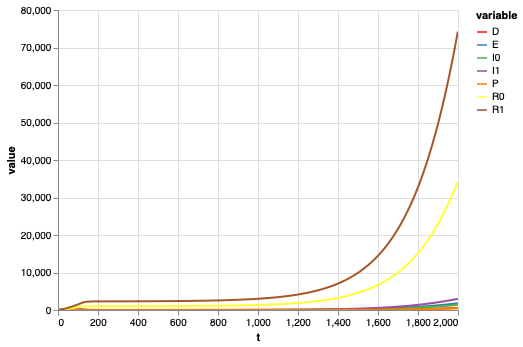

In [1912]:
alt.Chart(plot_values).mark_line().encode(
    x='t',
    y='value',
    color=alt.Color('variable', scale=alt.Scale(scheme="set1")),
    tooltip=['t','variable','value']
).properties(
).interactive()

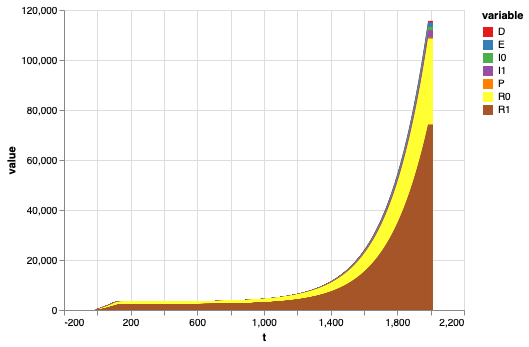

In [1913]:
alt.Chart(plot_values).mark_bar().encode(
    x='t',
    y=alt.Y('value', stack=True),
    color=alt.Color('variable', scale=alt.Scale(scheme="set1"))
).properties(
).interactive()